In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from tqdm import tqdm

LR = 0.01
RHO=0.1
WEIGHT_DECAY = 0.0
MOMENTUM = 0.9
IS_LAZY = True

SEED = 0

if IS_LAZY:
    os.environ['PT_HPU_LAZY_MODE'] = '1'
else:
    os.environ['PT_HPU_LAZY_MODE'] = '0'


In [ ]:
import habana_frameworks.torch.core as htcore
import habana_frameworks.torch.hpu.random as htrandom
from utils.SAM import SAM

htrandom.manual_seed_all(SEED)
torch.manual_seed(SEED)          # CPU 시드 고정
torch.cuda.manual_seed(SEED)     # 현재 GPU의 시드 고정
torch.cuda.manual_seed_all(SEED) # 모든 GPU의 시드 고정
np.random.seed(SEED)
device = torch.device("hpu")

class MinimalModel(nn.Module):
    linear1: nn.Module
    linear2: nn.Module

    def __init__(self):
        super(MinimalModel, self).__init__()
        self.linear1: nn.Module = nn.Linear(in_features=2, out_features=1, bias=False)
        self.linear2: nn.Module = nn.Linear(in_features=1, out_features=1, bias=False)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        out1 = self.linear1(x)
        out1 = self.activation(out1)
        out2 = self.linear2(out1)
        out2 = out2.flatten()
        return out2


model = MinimalModel().to(device)
if not IS_LAZY:
    model = torch.compile(model, backend="hpu_backend")

loss_func = nn.MSELoss()

X = np.array([[1.05, 0.95], [0.95, 1.05]])
y = np.array([1.0, -1.0])
epoch_nums = 50000

X = torch.tensor(X).to(device, dtype=torch.float32)
y = torch.tensor(y).to(device, dtype=torch.float32)

optimizer = SAM(model.parameters(), optim.SGD, lr=LR, rho=RHO, 
                weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

loss_list = []
state_dict_list = []
pbar = tqdm(range(epoch_nums))

# Full batch SAM
for epoch in pbar:
    optimizer.zero_grad()
    out = model(X)
    loss = loss_func(out, y)
    loss_list.append(loss.item())
    pbar.set_postfix({'loss': loss.item()})
    detached_state_dict = {}
    for name, param in model.state_dict().items():
        detached_state_dict[name] = param.detach().cpu().numpy()
    state_dict_list.append(detached_state_dict)
    loss.backward()
    htcore.mark_step()
    optimizer.first_step(zero_grad=True)
    htcore.mark_step()
    out2 = model(X)
    second_loss = loss_func(out2, y)
    second_loss.backward()
    htcore.mark_step()
    optimizer.second_step(zero_grad=True)
    htcore.mark_step()

import pickle as pkl
to_save = [loss_list, state_dict_list]
if IS_LAZY:
    with open("verify_lazy.pkl", 'wb') as f:
        pkl.dump(to_save, f, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open("verify_eager.pkl", 'wb') as f:
        pkl.dump(to_save, f, protocol=pkl.HIGHEST_PROTOCOL)

============================= HABANA PT BRIDGE CONFIGURATION =========================== 
 PT_HPU_LAZY_MODE = 1
 PT_RECIPE_CACHE_PATH = 
 PT_CACHE_FOLDER_DELETE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = 
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 2113409260 KB
------------------------------------------------------------------------------
 87%|████████████████████████████████████████████████████████████████████████████████▍           | 43740/50000 [02:23<00:20, 305.68it/s, loss=1.21e-6]

# Plot Section

In [3]:
import pickle as pkl

data_eager = pkl.load(open("verify_eager.pkl", 'rb'))
data_lazy = pkl.load(open("verify_lazy.pkl", 'rb'))

In [4]:
loss_eager = data_eager[0]
loss_lazy = data_lazy[0]

param_eager = np.array(data_eager[1])
param_lazy = np.array(data_lazy[1])

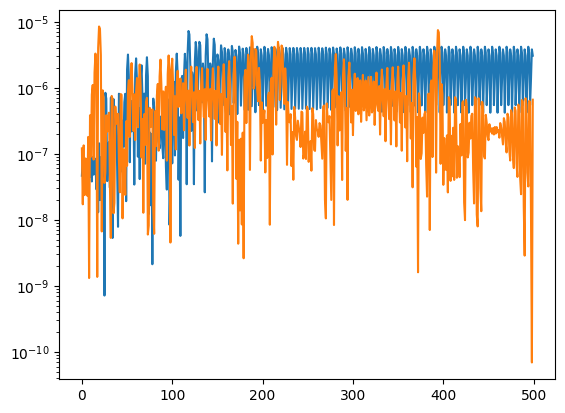

In [5]:
from matplotlib import pyplot as plt

plt.plot(loss_eager[17500:18000])
plt.plot(loss_lazy[17500:18000])
plt.yscale('log')
